## 패키지 로딩하기

In [1]:
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 예제 : 삼성전자
### 이번 과제는 노드에 나온 예제를 코딩해보고, 다른 주식 3개를 실습했다.

### 1. 데이터 불러오기
* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [2]:
ss_data_path  = os.getenv("HOME") + "/aiffel/stock_prediction/data/삼성전자.csv"   # 데이터 경로 지정
ss_df         = pd.read_csv(ss_data_path, index_col = "Date", parse_dates = True) # 데이터 불러오기
ss_ts         = ss_df["Close"]                                                    # 시계열 데이터로 준비
ss_ts.head()                                                                      # 앞에 5개만 보기

Date
2002-02-25    6640.0
2002-02-26    6740.0
2002-02-27    7000.0
2002-02-28    6860.0
2002-03-01    6860.0
Name: Close, dtype: float64

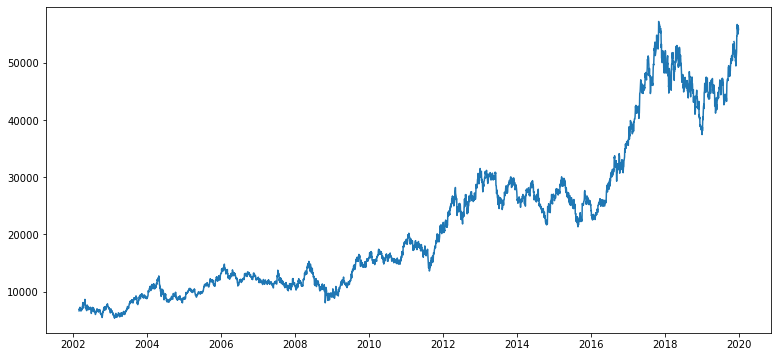

In [3]:
rcParams['figure.figsize'] = 13, 6 # matlab 차트의 기본 크기를 13, 6으로 지정해 준다.
plt.plot(ss_ts)                    # 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려진다.

### 2. 각종 전처리 수행
* 결측치 처리
* 로그 변환

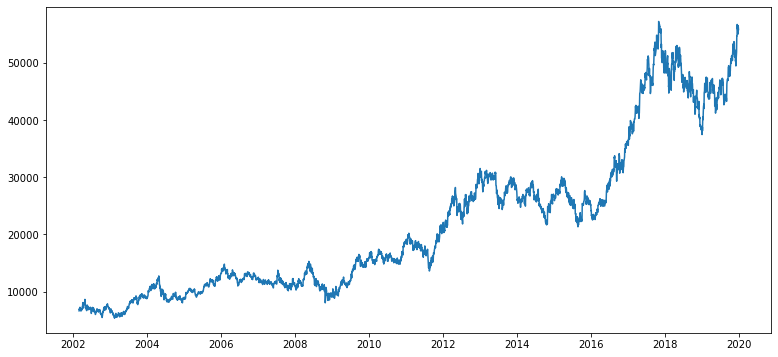

In [4]:
# 결측치 처리
ss_ts = ss_ts.interpolate(method = "time") # 보간법
                                           # interpolate는 선형으로 비례하여 결측값을 보간해준다. default는 interpolate(method = "values")
                                           # interpolate(method = "time")을 하면 시계열 날짜 index를 기준으로 결측값을 보간한다.
ss_ts[ss_ts.isna()]                        # Time Series에서 결측치가 있는 부분만 Series로 출력한다.
plt.plot(ss_ts)

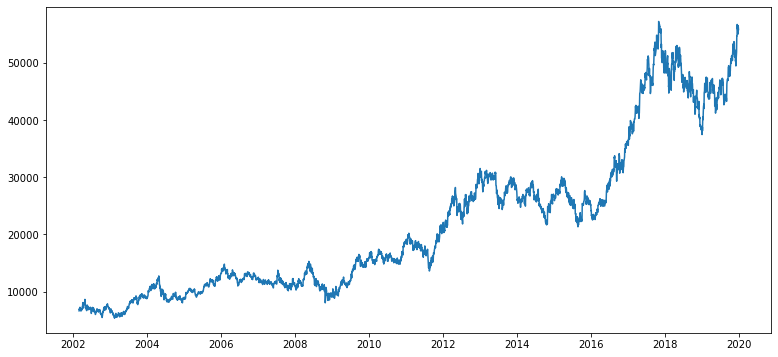

In [5]:
# 로그 변환
ss_ts_log = np.log(ss_ts)
plt.plot(ss_ts)

### 3. 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

In [6]:
# 정성적 그래프 분석 함수 만들기
def plot_rolling_statistics(timeseries, window = 12):
    rolmean = timeseries.rolling(window = window).mean() # 이동평균     시계열
    rolstd  = timeseries.rolling(window = window).std()  # 이동표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차를 시각화하기
    orig = plt.plot(timeseries, color = "blue",  label = "Original")
    mean = plt.plot(rolmean,    color = "red",   label = "Rolling Mean")
    std  = plt.plot(rolstd,     color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block = False)

In [7]:
# 정량적 Augmented Dicky-Fuller Test 함수 만들기
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출하기
    dftest = adfuller(timeseries, autolag = "AIC")
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력하기
    print("Results of Dickey-Fuller Test :")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

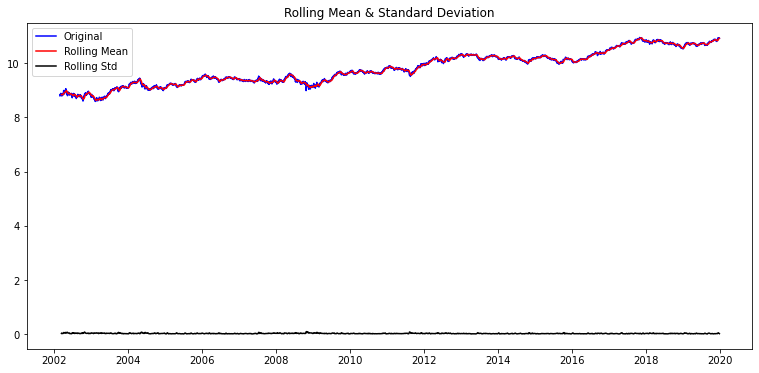

Results of Dickey-Fuller Test :
Test Statistic                   -0.675049
p-value                           0.853107
#Lags Used                        4.000000
Number of Observations Used    4468.000000
Critical Value (1%)              -3.431814
Critical Value (5%)              -2.862187
Critical Value (10%)             -2.567114
dtype: float64


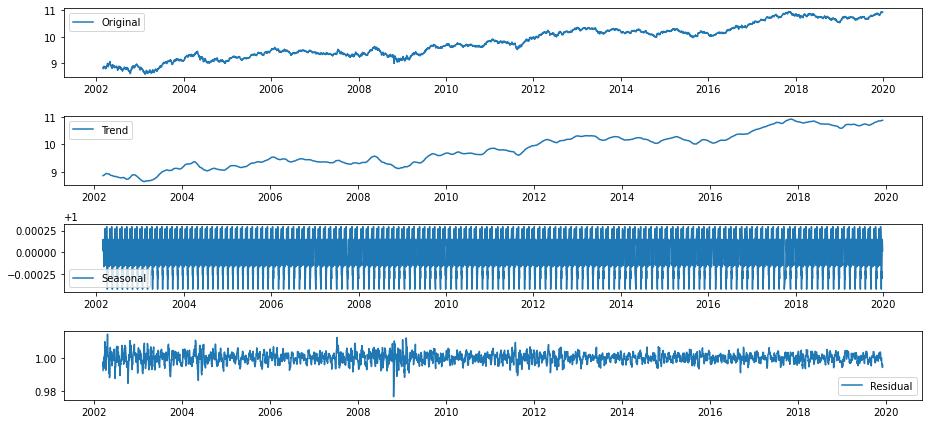

In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ss_ts_log, window = 12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ss_ts_log)

# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ss_ts_log, model = "multiplicative", period = 30)

ss_trend      = decomposition.trend
ss_seasonal   = decomposition.seasonal
ss_residual   = decomposition.resid

# 시각화 하기
plt.subplot(411)
plt.plot(ss_ts_log,   label = "Original")
plt.legend(loc = "best")

plt.subplot(412)
plt.plot(ss_trend,    label = "Trend")
plt.legend(loc = "best")

plt.subplot(413)
plt.plot(ss_seasonal, label = "Seasonal")
plt.legend(loc = "best")

plt.subplot(414)
plt.plot(ss_residual, label = "Residual")
plt.legend(loc = "best")

plt.tight_layout()

In [9]:
# Residual 안정성 확인
ss_residual.dropna(inplace = True)
augmented_dickey_fuller_test(ss_residual)

Results of Dickey-Fuller Test :
Test Statistic                -1.699322e+01
p-value                        8.837813e-30
#Lags Used                     2.900000e+01
Number of Observations Used    4.413000e+03
Critical Value (1%)           -3.431833e+00
Critical Value (5%)           -2.862195e+00
Critical Value (10%)          -2.567119e+00
dtype: float64


### 4. 학습, 테스트 데이터셋 생성
* 학습, 테스트 데이터셋 분리

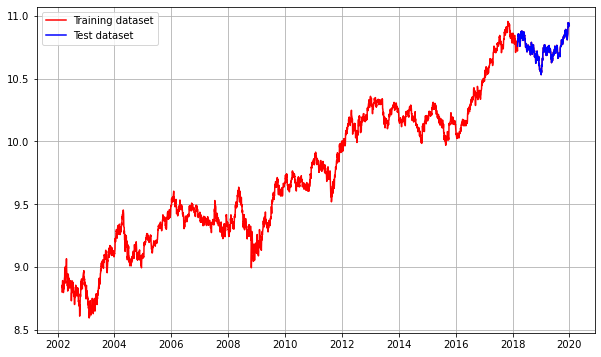

In [10]:
ss_train_data, ss_test_data = ss_ts_log[:int(len(ss_ts_log) * 0.9)], ss_ts_log[int(len(ss_ts_log) * 0.9):]

plt.figure(figsize = (10, 6))
plt.grid(True)
plt.plot(ss_ts_log,    c = "r", label = "Training dataset") # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(ss_test_data, c = "b", label = "Test dataset")
plt.legend()

### 5. 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

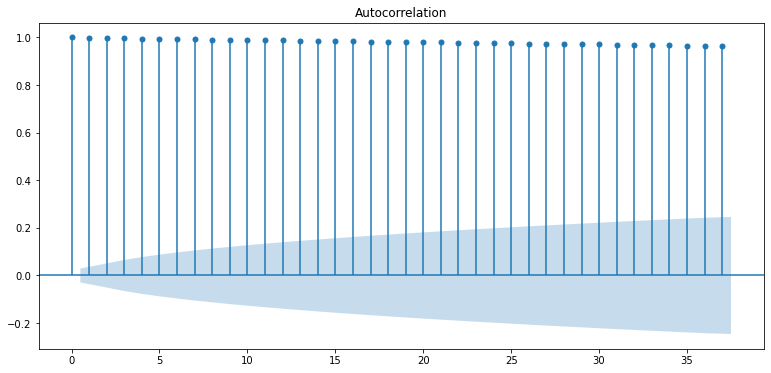

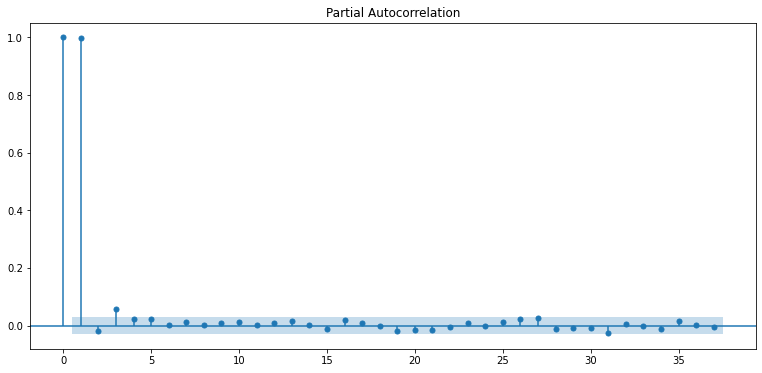

In [11]:
plot_acf(ss_ts_log)  # ACF  : Autocorrelation 그래프 그리기
plot_pacf(ss_ts_log) # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test :
Test Statistic                  -37.480040
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    4468.000000
Critical Value (1%)              -3.431814
Critical Value (5%)              -2.862187
Critical Value (10%)             -2.567114
dtype: float64


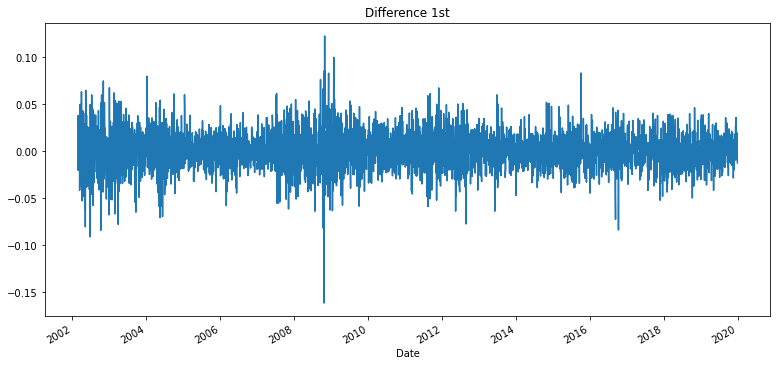

In [12]:
# 1차 차분 구하기
ss_diff_1 = ss_ts_log.diff(periods = 1).iloc[1:]
ss_diff_1.plot(title = "Difference 1st")

augmented_dickey_fuller_test(ss_diff_1)

In [13]:
# # 혹시 필요할 시 2차 차분 구하기
# ss_diff_2 = ss_diff_1.diff(periods = 1).iloc[1:]
# ss_diff_2.plot(title = "Difference 2nd")

# augmented_dickey_fuller_test(ss_diff_2)

### 6. ARIMA 모델 훈련과 테스트
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [14]:
# 모델 구축
ss_model    = ARIMA(ss_train_data, order = (1, 1, 0)) # order = (p = FACF, d, q = ACF)
ss_fitted_m = ss_model.fit(disp = -1)
print(ss_fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4024
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10092.430
Method:                       css-mle   S.D. of innovations              0.020
Date:                Mon, 01 Mar 2021   AIC                         -20178.861
Time:                        09:41:12   BIC                         -20159.961
Sample:                             1   HQIC                        -20172.163
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.472      0.141      -0.000       0.001
ar.L1.D.Close     0.0410      0.016      2.601      0.009       0.010       0.072
                                    Root

/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

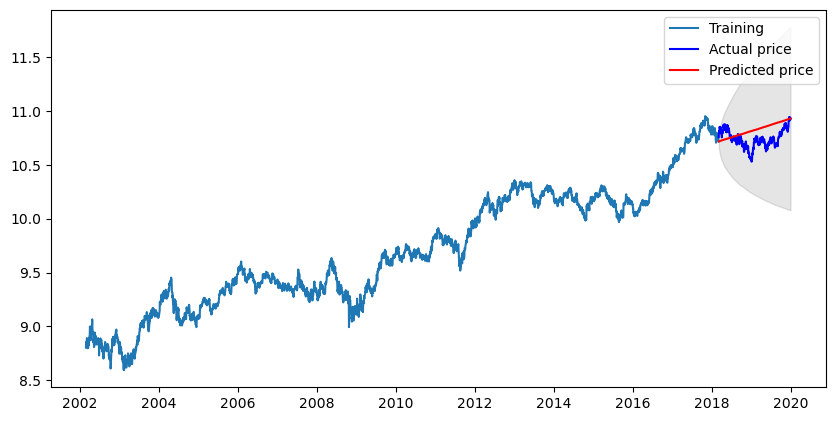

In [15]:
# Forecast : 결과가 fc에 담긴다.
ss_fc, ss_se, ss_conf = ss_fitted_m.forecast(len(ss_test_data), alpha = 0.05) # 95% conf

# pandas series로 만들기
ss_fc_series    = pd.Series(ss_fc,         index = ss_test_data.index)        # 예측결과
ss_lower_series = pd.Series(ss_conf[:, 0], index = ss_test_data.index)        # 예측결과의 하한 바운드
ss_upper_series = pd.Series(ss_conf[:, 1], index = ss_test_data.index)        # 예측결과의 상한 바운드

# 시각화하기
plt.figure(figsize = (10, 5), dpi = 100)
plt.plot(ss_train_data, label = "Training")
plt.plot(ss_test_data,  label = "Actual price",    c = "b")
plt.plot(ss_fc_series,  label = "Predicted price", c = "r")
plt.fill_between(ss_lower_series.index, ss_lower_series, ss_upper_series, color = "k", alpha = .10)
plt.legend()
plt.show()

In [16]:
ss_mse = mean_squared_error(np.exp(ss_test_data), np.exp(ss_fc))
print("MSE :", ss_mse)

ss_mae = mean_absolute_error(np.exp(ss_test_data), np.exp(ss_fc))
print("MAE :", ss_mae)

ss_rmse = math.sqrt(mean_squared_error(np.exp(ss_test_data), np.exp(ss_fc)))
print("RMSE :", ss_rmse)

ss_mape = np.mean(np.abs(np.exp(ss_fc) - np.exp(ss_test_data)) / np.abs(np.exp(ss_test_data)))
print("MAPE : {:.2f}%".format(ss_mape * 100))

MSE : 35676793.10676549
MAE : 5232.505957451497
RMSE : 5973.005366376753
MAPE : 11.63%


In [17]:
# 예제인 삼성전자는 11.63%의 오차율을 보이고 있다.

## SK 텔레콤

### 1. 데이터 불러오기

In [18]:
st_data_path  = os.getenv("HOME") + "/aiffel/stock_prediction/data/SK텔레콤.csv"  # 데이터 경로 지정
st_df         = pd.read_csv(st_data_path, index_col = "Date", parse_dates = True) # 데이터 불러오기
st_ts         = st_df["Close"]                                                    # 시계열 데이터로 준비
st_ts.head()                                                                      # 앞에 5개만 보기

Date
2002-04-24    265000.0
2002-04-25    261000.0
2002-04-26    257000.0
2002-04-29    244500.0
2002-04-30    251500.0
Name: Close, dtype: float64

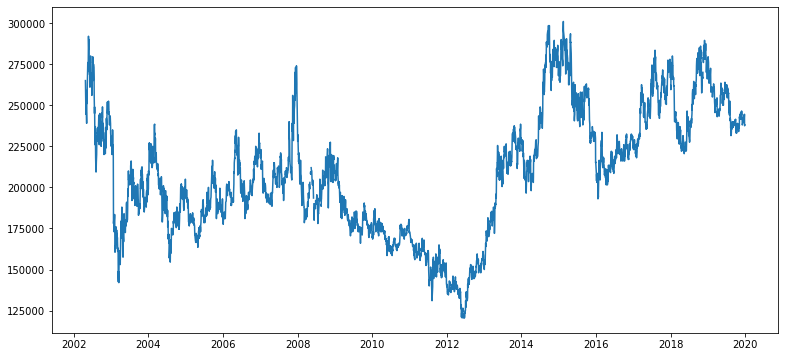

In [19]:
rcParams['figure.figsize'] = 13, 6 # matlab 차트의 기본 크기를 13, 6으로 지정해 준다.
plt.plot(st_ts)                    # 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려진다.

### 2. 각종 전처리 수행

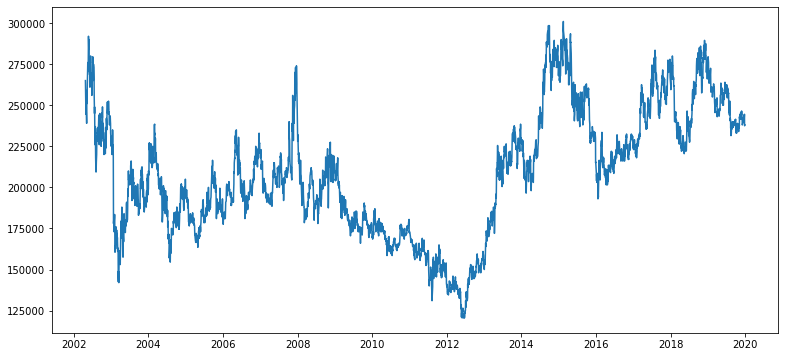

In [20]:
# 결측치 처리
st_ts = st_ts.interpolate(method = "time") # 보간법
                                           # interpolate는 선형으로 비례하여 결측값을 보간해준다. default는 interpolate(method = "values")
                                           # interpolate(method = "time")을 하면 시계열 날짜 index를 기준으로 결측값을 보간한다.
st_ts[st_ts.isna()]                        # Time Series에서 결측치가 있는 부분만 Series로 출력한다.
plt.plot(st_ts)

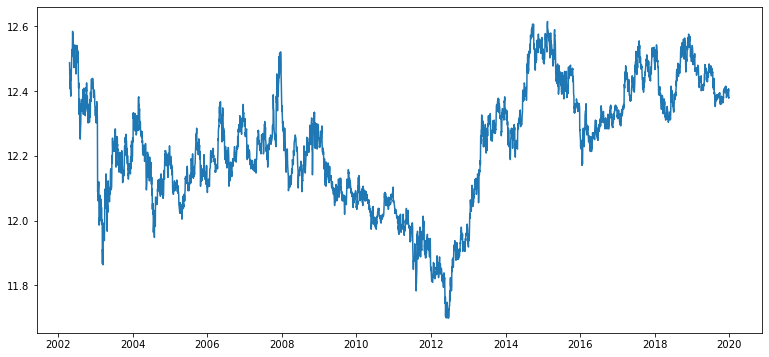

In [21]:
# 로그 변환
st_ts_log = np.log(st_ts)
plt.plot(st_ts_log)

### 3. 시계열 안정성 분석

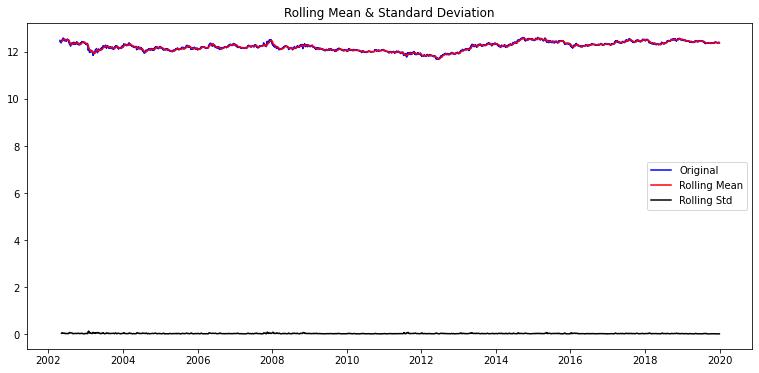

Results of Dickey-Fuller Test :
Test Statistic                   -2.663286
p-value                           0.080610
#Lags Used                       13.000000
Number of Observations Used    4417.000000
Critical Value (1%)              -3.431831
Critical Value (5%)              -2.862195
Critical Value (10%)             -2.567118
dtype: float64


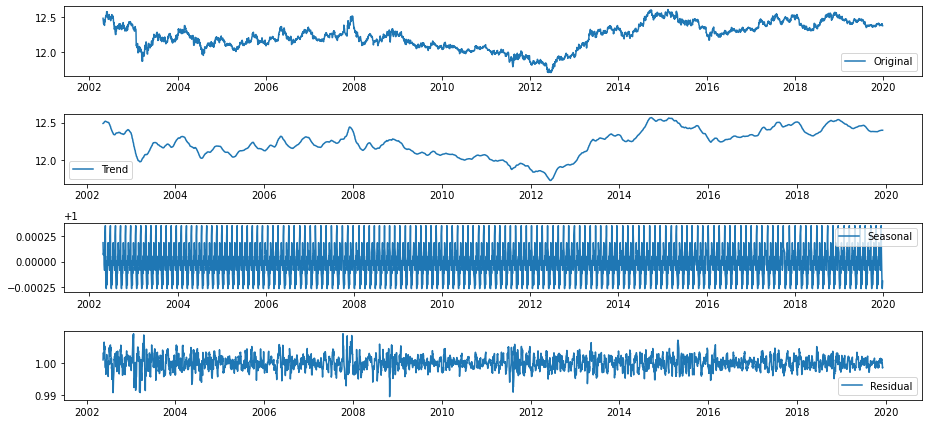

In [22]:
# 정성적 그래프 분석
plot_rolling_statistics(st_ts_log, window = 12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(st_ts_log)

# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(st_ts_log, model = "multiplicative", period = 30)

st_trend      = decomposition.trend
st_seasonal   = decomposition.seasonal
st_residual   = decomposition.resid

# 시각화 하기
plt.subplot(411)
plt.plot(st_ts_log,   label = "Original")
plt.legend(loc = "best")

plt.subplot(412)
plt.plot(st_trend,    label = "Trend")
plt.legend(loc = "best")

plt.subplot(413)
plt.plot(st_seasonal, label = "Seasonal")
plt.legend(loc = "best")

plt.subplot(414)
plt.plot(st_residual, label = "Residual")
plt.legend(loc = "best")

plt.tight_layout()

In [23]:
# Residual 안정성 확인
st_residual.dropna(inplace = True)
augmented_dickey_fuller_test(st_residual)

Results of Dickey-Fuller Test :
Test Statistic                -1.629262e+01
p-value                        3.326584e-29
#Lags Used                     3.100000e+01
Number of Observations Used    4.369000e+03
Critical Value (1%)           -3.431848e+00
Critical Value (5%)           -2.862202e+00
Critical Value (10%)          -2.567122e+00
dtype: float64


### 4. 학습, 테스트 데이터셋 생성

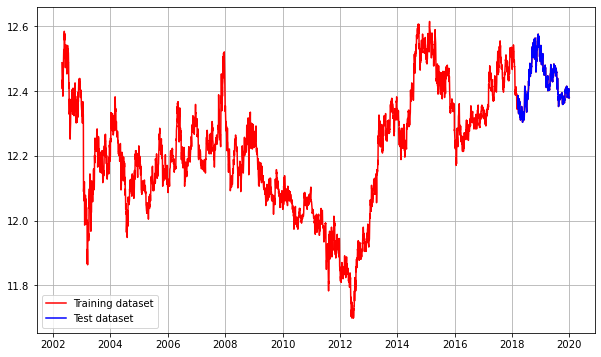

In [24]:
st_train_data, st_test_data = st_ts_log[:int(len(st_ts_log) * 0.9)], st_ts_log[int(len(st_ts_log) * 0.9):]

plt.figure(figsize = (10, 6))
plt.grid(True)
plt.plot(st_ts_log,    c = "r", label = "Training dataset") # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(st_test_data, c = "b", label = "Test dataset")
plt.legend()

### 5. 적정 ARIMA 모수 찾기

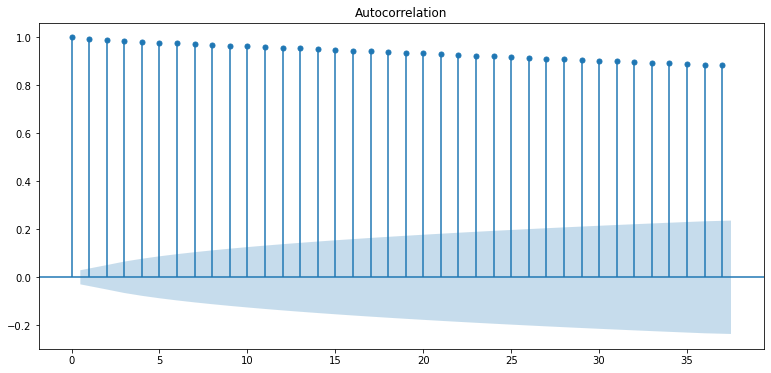

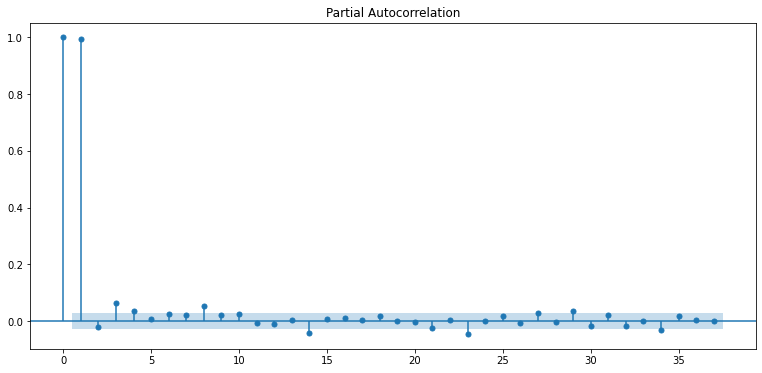

In [25]:
plot_acf(st_ts_log)  # ACF  : Autocorrelation 그래프 그리기
plot_pacf(st_ts_log) # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test :
Test Statistic                  -25.425375
p-value                           0.000000
#Lags Used                        8.000000
Number of Observations Used    4421.000000
Critical Value (1%)              -3.431830
Critical Value (5%)              -2.862194
Critical Value (10%)             -2.567118
dtype: float64


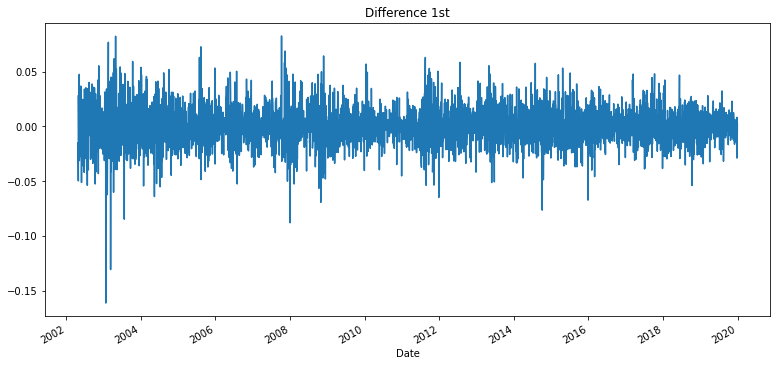

In [26]:
# 1차 차분 구하기
st_diff_1 = st_ts_log.diff(periods = 1).iloc[1:]
st_diff_1.plot(title = "Difference 1st")

augmented_dickey_fuller_test(st_diff_1)

In [27]:
# # 혹시 필요할 시 2차 차분 구하기
# st_diff_2 = st_diff_1.diff(periods = 1).iloc[1:]
# st_diff_2.plot(title = "Difference 2nd")

# augmented_dickey_fuller_test(st_diff_2)

### 6. ARIMA 모델 훈련과 테스트

In [28]:
# 모델 구축
st_model    = ARIMA(st_train_data, order = (1, 1, 0)) # order = (p = FACF, d, q = ACF)
st_fitted_m = st_model.fit(disp = -1)
print(st_fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3986
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10446.822
Method:                       css-mle   S.D. of innovations              0.018
Date:                Mon, 01 Mar 2021   AIC                         -20887.645
Time:                        09:41:14   BIC                         -20868.773
Sample:                             1   HQIC                        -20880.954
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.174e-05      0.000     -0.111      0.912      -0.001       0.001
ar.L1.D.Close     0.0252      0.016      1.592      0.111      -0.006       0.056
                                    Root

/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

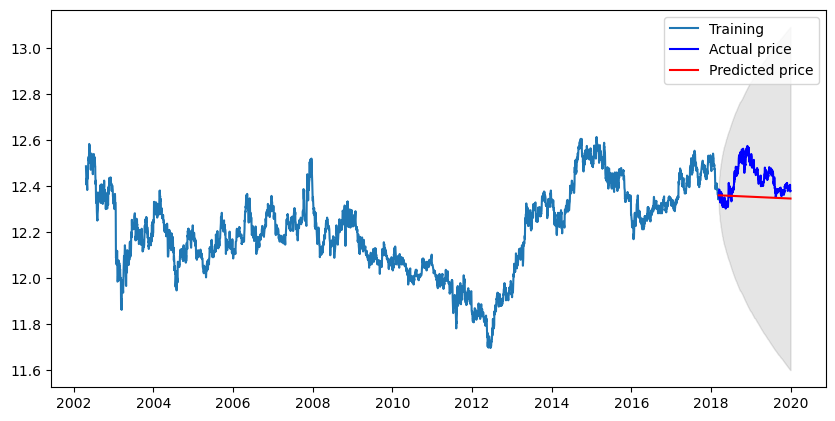

In [29]:
# Forecast : 결과가 fc에 담긴다.
st_fc, st_se, st_conf = st_fitted_m.forecast(len(st_test_data), alpha = 0.05) # 95% conf

# pandas series로 만들기
st_fc_series    = pd.Series(st_fc,         index = st_test_data.index)        # 예측결과
st_lower_series = pd.Series(st_conf[:, 0], index = st_test_data.index)        # 예측결과의 하한 바운드
st_upper_series = pd.Series(st_conf[:, 1], index = st_test_data.index)        # 예측결과의 상한 바운드

# 시각화하기
plt.figure(figsize = (10, 5), dpi = 100)
plt.plot(st_train_data, label = "Training")
plt.plot(st_test_data,  label = "Actual price",    c = "b")
plt.plot(st_fc_series,  label = "Predicted price", c = "r")
plt.fill_between(st_lower_series.index, st_lower_series, st_upper_series, color = "k", alpha = .10)
plt.legend()
plt.show()

In [30]:
st_mse = mean_squared_error(np.exp(st_test_data), np.exp(st_fc))
print("MSE :", st_mse)

st_mae = mean_absolute_error(np.exp(st_test_data), np.exp(st_fc))
print("MAE :", st_mae)

st_rmse = math.sqrt(mean_squared_error(np.exp(st_test_data), np.exp(st_fc)))
print("RMSE :", st_rmse)

st_mape = np.mean(np.abs(np.exp(st_fc) - np.exp(st_test_data)) / np.abs(np.exp(st_test_data)))
print("MAPE : {:.2f}%".format(st_mape * 100))

MSE : 619173028.9646604
MAE : 20367.126725715098
RMSE : 24883.187676916725
MAPE : 7.81%


In [31]:
# SK텔레콤은 7.81%의 오차율을 보이고 있다.

## 대한항공

### 1. 데이터 불러오기

In [32]:
ka_data_path  = os.getenv("HOME") + "/aiffel/stock_prediction/data/대한항공.csv"  # 데이터 경로 지정
ka_df         = pd.read_csv(ka_data_path, index_col = "Date", parse_dates = True) # 데이터 불러오기
ka_ts         = ka_df["Close"]                                                    # 시계열 데이터로 준비
ka_ts.head()                                                                      # 앞에 5개만 보기

Date
2002-04-24    17717.308594
2002-04-25    17417.861328
2002-04-26    19464.085938
2002-04-29    18266.296875
2002-04-30    20062.980469
Name: Close, dtype: float64

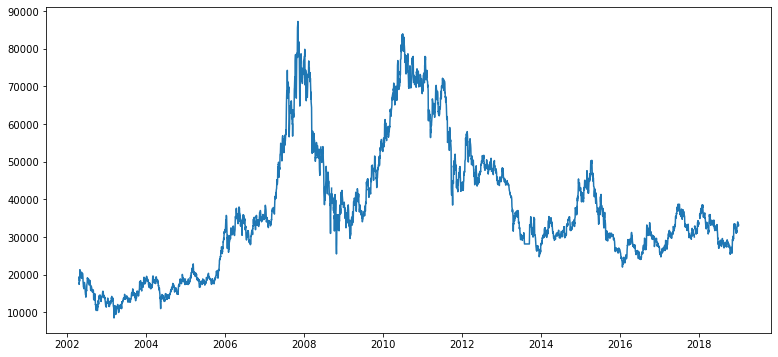

In [33]:
rcParams['figure.figsize'] = 13, 6 # matlab 차트의 기본 크기를 13, 6으로 지정해 준다.
plt.plot(ka_ts)                    # 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려진다.

### 2. 각종 전처리 수행

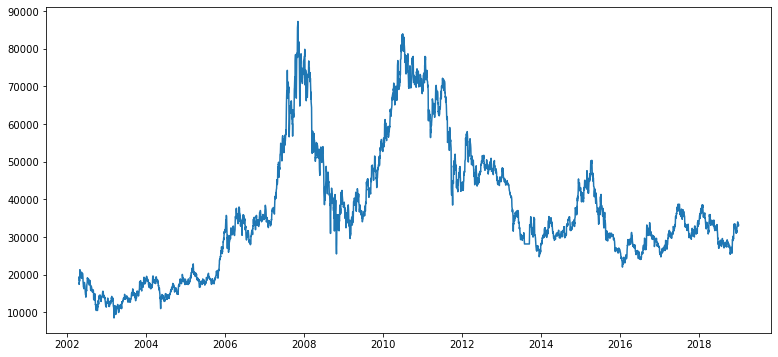

In [34]:
# 결측치 처리
ka_ts = ka_ts.interpolate(method = "time") # 보간법
                                           # interpolate는 선형으로 비례하여 결측값을 보간해준다. default는 interpolate(method = "values")
                                           # interpolate(method = "time")을 하면 시계열 날짜 index를 기준으로 결측값을 보간한다.
ka_ts[ka_ts.isna()]                        # Time Series에서 결측치가 있는 부분만 Series로 출력한다.
plt.plot(ka_ts)

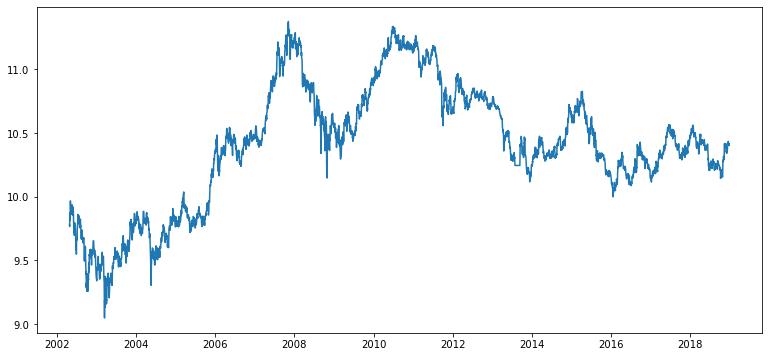

In [35]:
# 로그 변환
ka_ts_log = np.log(ka_ts)
plt.plot(ka_ts_log)

### 3. 시계열 안정성 분석

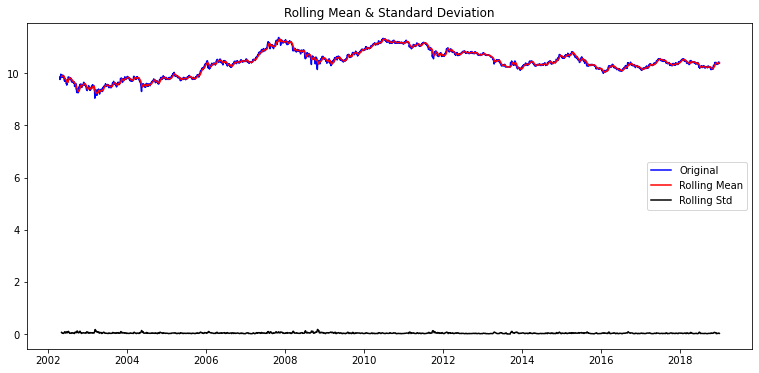

Results of Dickey-Fuller Test :
Test Statistic                   -1.714563
p-value                           0.423625
#Lags Used                        9.000000
Number of Observations Used    4175.000000
Critical Value (1%)              -3.431917
Critical Value (5%)              -2.862233
Critical Value (10%)             -2.567139
dtype: float64


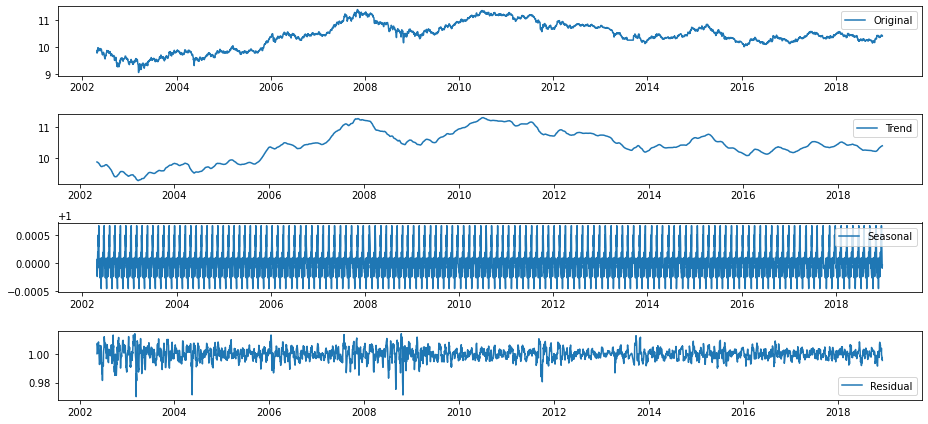

In [36]:
# 정성적 그래프 분석
plot_rolling_statistics(ka_ts_log, window = 12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ka_ts_log)

# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ka_ts_log, model = "multiplicative", period = 30)

ka_trend      = decomposition.trend
ka_seasonal   = decomposition.seasonal
ka_residual   = decomposition.resid

# 시각화 하기
plt.subplot(411)
plt.plot(ka_ts_log,   label = "Original")
plt.legend(loc = "best")

plt.subplot(412)
plt.plot(ka_trend,    label = "Trend")
plt.legend(loc = "best")

plt.subplot(413)
plt.plot(ka_seasonal, label = "Seasonal")
plt.legend(loc = "best")

plt.subplot(414)
plt.plot(ka_residual, label = "Residual")
plt.legend(loc = "best")

plt.tight_layout()

In [37]:
# Residual 안정성 확인
ka_residual.dropna(inplace = True)
augmented_dickey_fuller_test(ka_residual)

Results of Dickey-Fuller Test :
Test Statistic                -1.713600e+01
p-value                        7.097192e-30
#Lags Used                     2.900000e+01
Number of Observations Used    4.125000e+03
Critical Value (1%)           -3.431936e+00
Critical Value (5%)           -2.862241e+00
Critical Value (10%)          -2.567143e+00
dtype: float64


### 4. 학습, 테스트 데이터셋 생성

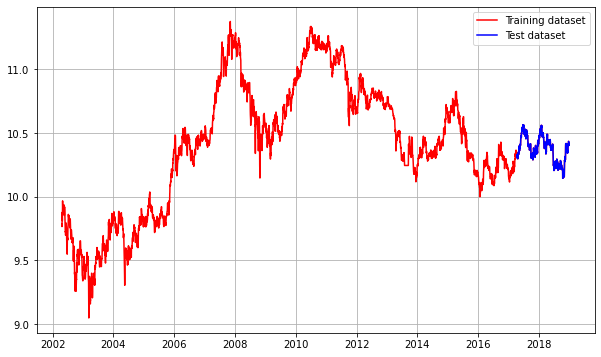

In [38]:
ka_train_data, ka_test_data = ka_ts_log[:int(len(ka_ts_log) * 0.9)], ka_ts_log[int(len(ka_ts_log) * 0.9):]

plt.figure(figsize = (10, 6))
plt.grid(True)
plt.plot(ka_ts_log,    c = "r", label = "Training dataset") # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(ka_test_data, c = "b", label = "Test dataset")
plt.legend()

### 5. 적정 ARIMA 모수 찾기

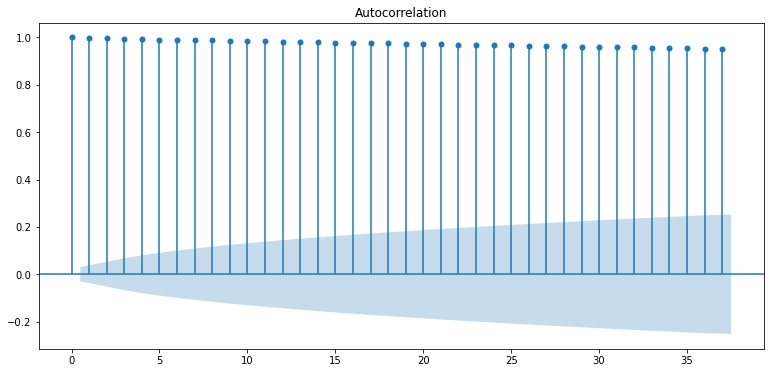

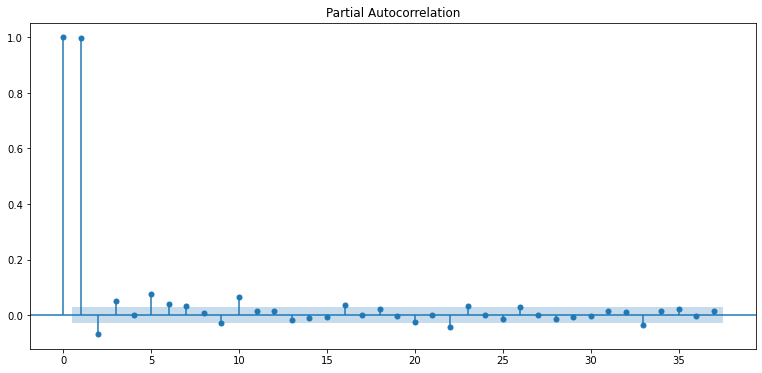

In [39]:
plot_acf(ka_ts_log)  # ACF  : Autocorrelation 그래프 그리기
plot_pacf(ka_ts_log) # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test :
Test Statistic                  -24.011363
p-value                           0.000000
#Lags Used                        8.000000
Number of Observations Used    4175.000000
Critical Value (1%)              -3.431917
Critical Value (5%)              -2.862233
Critical Value (10%)             -2.567139
dtype: float64


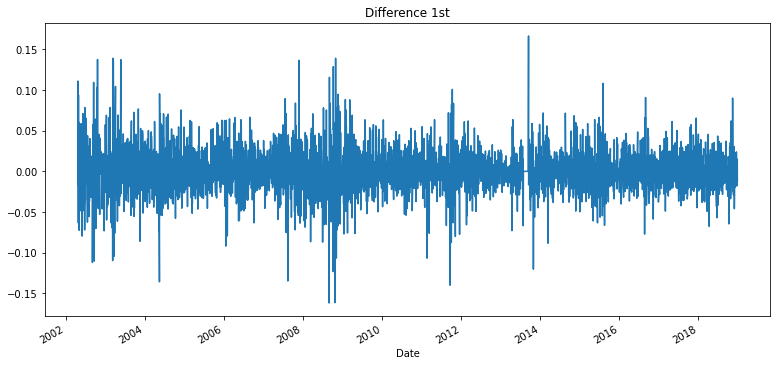

In [40]:
# 1차 차분 구하기
ka_diff_1 = ka_ts_log.diff(periods = 1).iloc[1:]
ka_diff_1.plot(title = "Difference 1st")

augmented_dickey_fuller_test(ka_diff_1)

In [41]:
# # 혹시 필요할 시 2차 차분 구하기
# ka_diff_2 = ka_diff_1.diff(periods = 1).iloc[1:]
# ka_diff_2.plot(title = "Difference 2nd")

# augmented_dickey_fuller_test(ka_diff_2)

### 6. ARIMA 모델 훈련과 테스트

In [42]:
# 모델 구축
ka_model    = ARIMA(ka_train_data, order = (1, 1, 0)) # order = (p = FACF, d, q = ACF)
ka_fitted_m = ka_model.fit(disp = -1)
print(ka_fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3765
Model:                 ARIMA(1, 1, 0)   Log Likelihood                8190.880
Method:                       css-mle   S.D. of innovations              0.027
Date:                Mon, 01 Mar 2021   AIC                         -16375.759
Time:                        09:41:16   BIC                         -16357.059
Sample:                             1   HQIC                        -16369.110
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.000      0.300      0.764      -0.001       0.001
ar.L1.D.Close     0.0679      0.016      4.176      0.000       0.036       0.100
                                    Root

/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

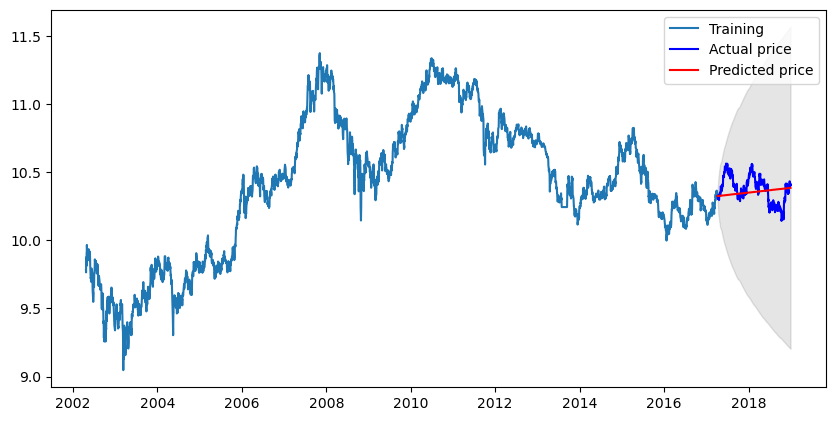

In [43]:
# Forecast : 결과가 fc에 담긴다.
ka_fc, ka_se, ka_conf = ka_fitted_m.forecast(len(ka_test_data), alpha = 0.05) # 95% conf

# pandas series로 만들기
ka_fc_series    = pd.Series(ka_fc,         index = ka_test_data.index)        # 예측결과
ka_lower_series = pd.Series(ka_conf[:, 0], index = ka_test_data.index)        # 예측결과의 하한 바운드
ka_upper_series = pd.Series(ka_conf[:, 1], index = ka_test_data.index)        # 예측결과의 상한 바운드

# 시각화하기
plt.figure(figsize = (10, 5), dpi = 100)
plt.plot(ka_train_data, label = "Training")
plt.plot(ka_test_data,  label = "Actual price",    c = "b")
plt.plot(ka_fc_series,  label = "Predicted price", c = "r")
plt.fill_between(ka_lower_series.index, ka_lower_series, ka_upper_series, color = "k", alpha = .10)
plt.legend()
plt.show()

In [44]:
ka_mse = mean_squared_error(np.exp(ka_test_data), np.exp(ka_fc))
print("MSE :", ka_mse)

ka_mae = mean_absolute_error(np.exp(ka_test_data), np.exp(ka_fc))
print("MAE :", ka_mae)

ka_rmse = math.sqrt(mean_squared_error(np.exp(ka_test_data), np.exp(ka_fc)))
print("RMSE :", ka_rmse)

ka_mape = np.mean(np.abs(np.exp(ka_fc) - np.exp(ka_test_data)) / np.abs(np.exp(ka_test_data)))
print("MAPE : {:.2f}%".format(ka_mape * 100))

MSE : 12940650.95790274
MAE : 2914.254369058854
RMSE : 3597.3116292451978
MAPE : 8.98%


In [45]:
# 대한항공은 8.98%의 오차율을 보이고 있다.

## 현대 자동차

### 1. 데이터 불러오기

In [46]:
hm_data_path  = os.getenv("HOME") + "/aiffel/stock_prediction/data/현대자동차.csv" # 데이터 경로 지정
hm_df         = pd.read_csv(hm_data_path, index_col = "Date", parse_dates = True) # 데이터 불러오기
hm_ts         = hm_df["Close"]                                                    # 시계열 데이터로 준비
hm_ts.head()                                                                      # 앞에 5개만 보기

Date
2002-04-24    53900.0
2002-04-25    50000.0
2002-04-26    50000.0
2002-04-29    48300.0
2002-04-30    48000.0
Name: Close, dtype: float64

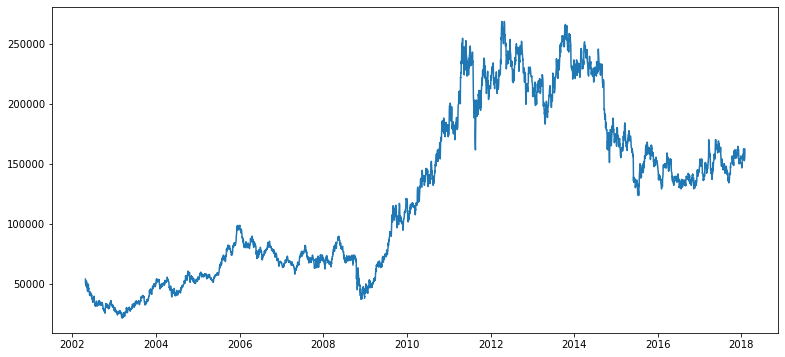

In [47]:
rcParams['figure.figsize'] = 13, 6 # matlab 차트의 기본 크기를 13, 6으로 지정해 준다.
plt.plot(hm_ts)                    # 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려진다.

### 2. 각종 전처리 수행

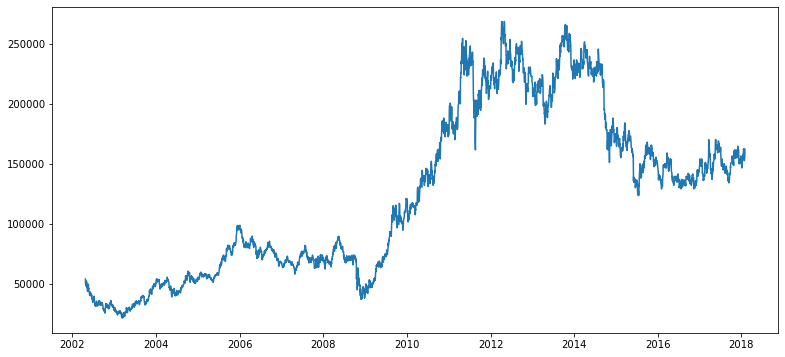

In [48]:
# 결측치 처리
hm_ts = hm_ts.interpolate(method = "time") # 보간법
                                           # interpolate는 선형으로 비례하여 결측값을 보간해준다. default는 interpolate(method = "values")
                                           # interpolate(method = "time")을 하면 시계열 날짜 index를 기준으로 결측값을 보간한다.
hm_ts[hm_ts.isna()]                        # Time Series에서 결측치가 있는 부분만 Series로 출력한다.
plt.plot(hm_ts)

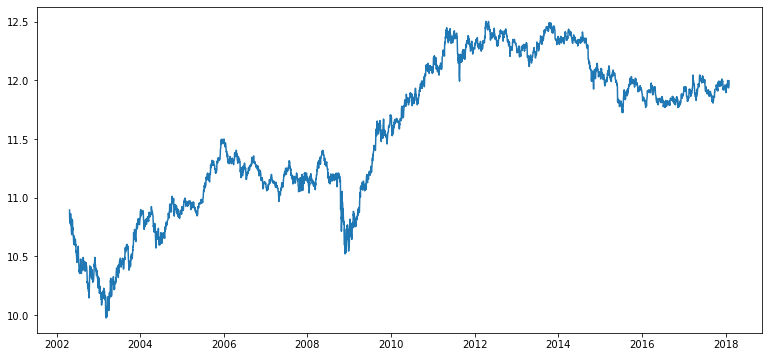

In [49]:
# 로그 변환
hm_ts_log = np.log(hm_ts)
plt.plot(hm_ts_log)

### 3. 시계열 안정성 분석

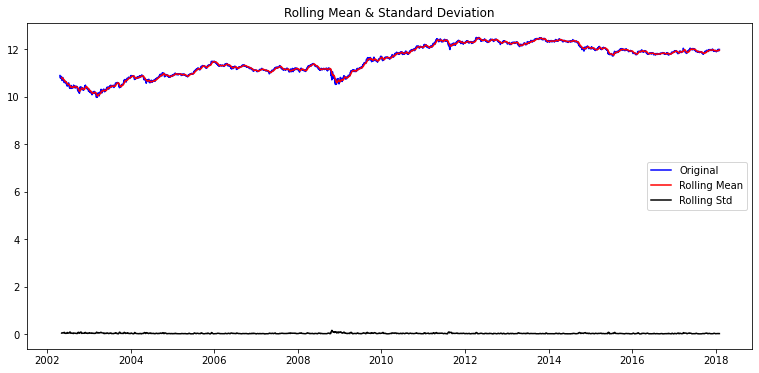

Results of Dickey-Fuller Test :
Test Statistic                   -1.212813
p-value                           0.668060
#Lags Used                        4.000000
Number of Observations Used    3958.000000
Critical Value (1%)              -3.432003
Critical Value (5%)              -2.862271
Critical Value (10%)             -2.567159
dtype: float64


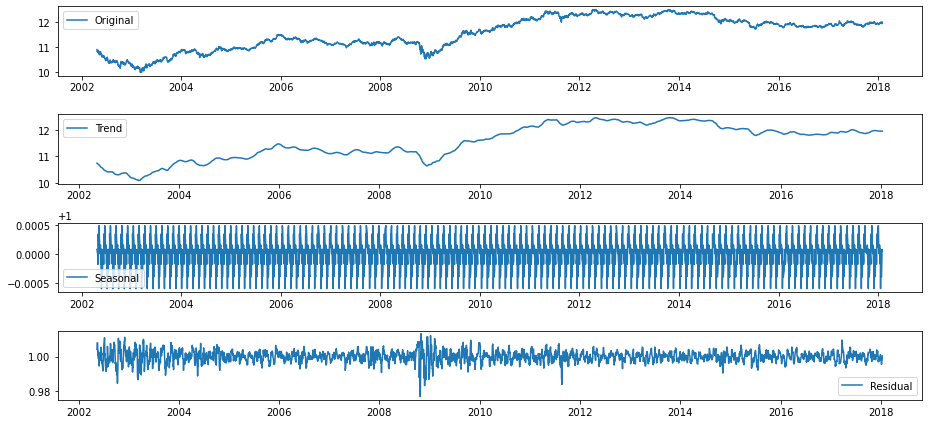

In [50]:
# 정성적 그래프 분석
plot_rolling_statistics(hm_ts_log, window = 12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(hm_ts_log)

# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(hm_ts_log, model = "multiplicative", period = 30)

hm_trend      = decomposition.trend
hm_seasonal   = decomposition.seasonal
hm_residual   = decomposition.resid

# 시각화 하기
plt.subplot(411)
plt.plot(hm_ts_log,   label = "Original")
plt.legend(loc = "best")

plt.subplot(412)
plt.plot(hm_trend,    label = "Trend")
plt.legend(loc = "best")

plt.subplot(413)
plt.plot(hm_seasonal, label = "Seasonal")
plt.legend(loc = "best")

plt.subplot(414)
plt.plot(hm_residual, label = "Residual")
plt.legend(loc = "best")

plt.tight_layout()

In [51]:
# Residual 안정성 확인
hm_residual.dropna(inplace = True)
augmented_dickey_fuller_test(hm_residual)

Results of Dickey-Fuller Test :
Test Statistic                -1.603497e+01
p-value                        6.000104e-29
#Lags Used                     2.900000e+01
Number of Observations Used    3.903000e+03
Critical Value (1%)           -3.432027e+00
Critical Value (5%)           -2.862281e+00
Critical Value (10%)          -2.567164e+00
dtype: float64


### 4. 학습, 테스트 데이터셋 생성

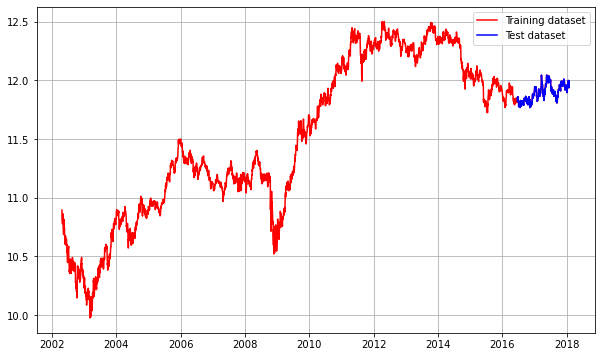

In [52]:
hm_train_data, hm_test_data = hm_ts_log[:int(len(hm_ts_log) * 0.9)], hm_ts_log[int(len(hm_ts_log) * 0.9):]

plt.figure(figsize = (10, 6))
plt.grid(True)
plt.plot(hm_ts_log,    c = "r", label = "Training dataset") # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(hm_test_data, c = "b", label = "Test dataset")
plt.legend()

### 5. 적정 ARIMA 모수 찾기

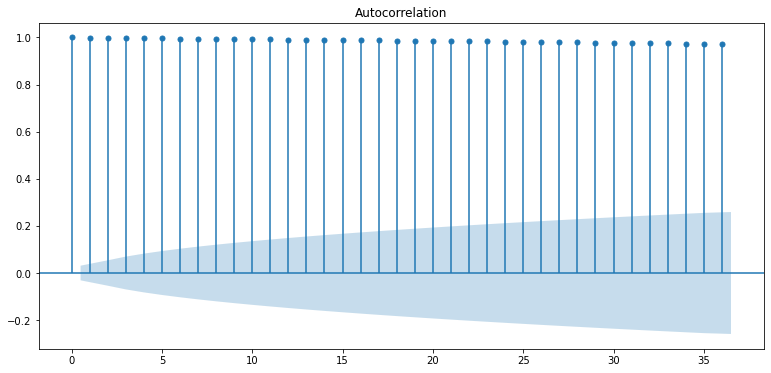

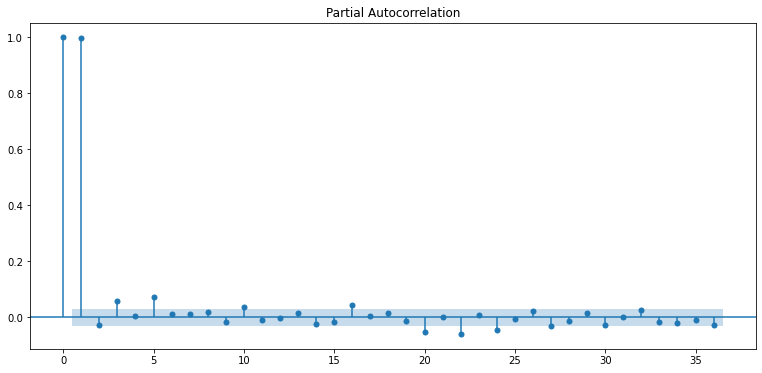

In [53]:
plot_acf(hm_ts_log)  # ACF  : Autocorrelation 그래프 그리기
plot_pacf(hm_ts_log) # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test :
Test Statistic                  -35.024912
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    3958.000000
Critical Value (1%)              -3.432003
Critical Value (5%)              -2.862271
Critical Value (10%)             -2.567159
dtype: float64


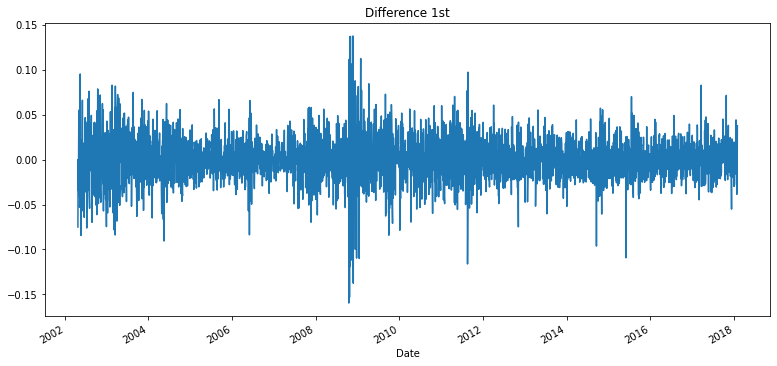

In [54]:
# 1차 차분 구하기
hm_diff_1 = hm_ts_log.diff(periods = 1).iloc[1:]
hm_diff_1.plot(title = "Difference 1st")

augmented_dickey_fuller_test(hm_diff_1)

In [55]:
# # 혹시 필요할 시 2차 차분 구하기
# hm_diff_2 = hm_diff_1.diff(periods = 1).iloc[1:]
# hm_diff_2.plot(title = "Difference 2nd")

# augmented_dickey_fuller_test(hm_diff_2)

### 6. ARIMA 모델 훈련과 테스트

In [56]:
# 모델 구축
hm_model    = ARIMA(hm_train_data, order = (1, 1, 0)) # order = (p = FACF, d, q = ACF)
hm_fitted_m = hm_model.fit(disp = -1)
print(hm_fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3565
Model:                 ARIMA(1, 1, 0)   Log Likelihood                8187.979
Method:                       css-mle   S.D. of innovations              0.024
Date:                Mon, 01 Mar 2021   AIC                         -16369.958
Time:                        09:41:18   BIC                         -16351.421
Sample:                             1   HQIC                        -16363.348
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      0.621      0.535      -0.001       0.001
ar.L1.D.Close     0.0127      0.017      0.760      0.447      -0.020       0.046
                                    Root

/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

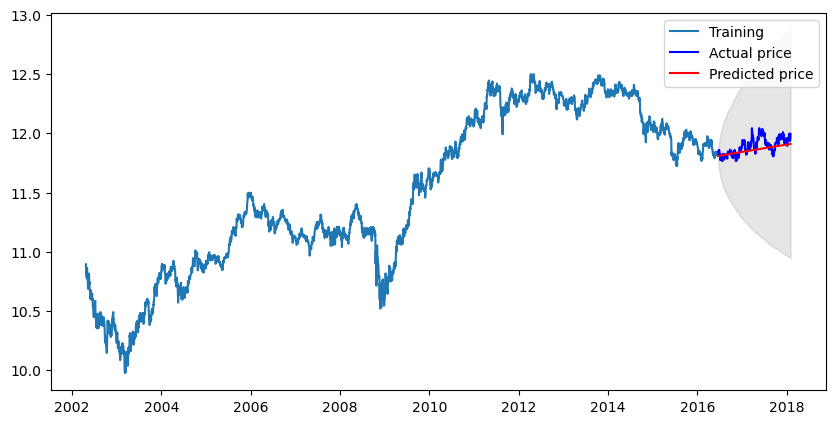

In [57]:
# Forecast : 결과가 fc에 담긴다.
hm_fc, hm_se, hm_conf = hm_fitted_m.forecast(len(hm_test_data), alpha = 0.05) # 95% conf

# pandas series로 만들기
hm_fc_series    = pd.Series(hm_fc,         index = hm_test_data.index) # 예측결과
hm_lower_series = pd.Series(hm_conf[:, 0], index = hm_test_data.index) # 예측결과의 하한 바운드
hm_upper_series = pd.Series(hm_conf[:, 1], index = hm_test_data.index) # 예측결과의 상한 바운드

# 시각화하기
plt.figure(figsize = (10, 5), dpi = 100)
plt.plot(hm_train_data, label = "Training")
plt.plot(hm_test_data,  label = "Actual price",    c = "b")
plt.plot(hm_fc_series,  label = "Predicted price", c = "r")
plt.fill_between(hm_lower_series.index, hm_lower_series, hm_upper_series, color = "k", alpha = .10)
plt.legend()
plt.show()

In [58]:
hm_mse = mean_squared_error(np.exp(hm_test_data), np.exp(hm_fc))
print("MSE :", hm_mse)

hm_mae = mean_absolute_error(np.exp(hm_test_data), np.exp(hm_fc))
print("MAE :", hm_mae)

hm_rmse = math.sqrt(mean_squared_error(np.exp(hm_test_data), np.exp(hm_fc)))
print("RMSE :", hm_rmse)

hm_mape = np.mean(np.abs(np.exp(hm_fc) - np.exp(hm_test_data)) / np.abs(np.exp(hm_test_data)))
print("MAPE : {:.2f}%".format(hm_mape * 100))

MSE : 88770117.77854818
MAE : 7094.186971507726
RMSE : 9421.789521027742
MAPE : 4.64%


In [59]:
# 현대자동차는 4.64%의 오차율을 보이고 있다.